# Assignment02. Bigger data and communications

## Load the NYC 311 Data as a JSON API

In [1]:
!pip install fiona
!pip install geopandas
!pip install adjustText
!pip install plotly
!pip install mapclassify

In [1]:
# To ignore unimporant system warnings
import warnings
warnings.filterwarnings("ignore")

# We will use Pandas, Numpy, and Matplotlib which is a package for visualization with Python
import pandas as pd
import numpy as np

# Load a required package 
# This is a library for accessing and parsing data through URLs
from urllib.parse import urlencode
import urllib.request, json 
from bs4 import BeautifulSoup # for web scraping
import fiona
import plotly.express as px
import geopandas as gpd
import adjustText as aT
import seaborn as sns # visualization styling package
import plotly.graph_objects as go
import urllib, json


# A magic functin that renders the figure in a notebook 
%matplotlib inline 

from matplotlib import pyplot as plt

In [3]:
API = 'https://data.cityofnewyork.us/resource/erm2-nwe9.csv?'

## Query the Noise Data

In [4]:
query = {'$select': 'created_date, complaint_type, resolution_description, incident_zip, borough, latitude, longitude',
         '$where': 'complaint_type="Noise" OR complaint_type="Noise - Residential" OR complaint_type="Noise - Street/Sidewalk" OR complaint_type="Noise - Vehicle" OR complaint_type="Noise - Commercial" OR complaint_type="Noise - Park" OR complaint_type="Noise - House of Worship" AND status="Closed"',
         '$order': 'created_date',
         '$limit': 5000000} #change to 5000000 later

df = pd.read_csv(API + urlencode(query),
                 parse_dates = ['created_date'],
                 dtype = {'incident_zip':'str'})
df.head()

,created_date,complaint_type,resolution_description,incident_zip,borough,latitude,longitude
0,2010-01-01 00:03:46,Noise - Residential,The Police Department responded to the complai...,11230,BROOKLYN,40.612155,-73.955036
1,2010-01-01 00:08:02,Noise - Residential,The Police Department responded to the complai...,11220,BROOKLYN,40.635708,-74.006853
2,2010-01-01 00:08:29,Noise - Residential,The Police Department responded to the complai...,10036,MANHATTAN,40.759486,-73.989135
3,2010-01-01 00:08:30,Noise - Residential,The Police Department responded to the complai...,10303,STATEN ISLAND,40.634762,-74.169727
4,2010-01-01 00:15:08,Noise - Residential,The Police Department responded to the complai...,11355,QUEENS,40.755060,-73.832251


In [5]:
df.shape[0]

4808042

In [6]:
df.dtypes

created_date              datetime64[ns]
complaint_type                    object
resolution_description            object
incident_zip                      object
borough                           object
latitude                         float64
longitude                        float64
dtype: object

## Clean up the DataFrame

In [7]:
df = df.rename(columns={"created_date": "Date", "complaint_type": "Complaint", "resolution_description":"Resolution", "incident_zip": "Zipcode", "borough":"Borough"})
df["Complaint"] = df["Complaint"].str.replace("Noise -", "")
df.head()

,Date,Complaint,Resolution,Zipcode,Borough,latitude,longitude
0,2010-01-01 00:03:46,Residential,The Police Department responded to the complai...,11230,BROOKLYN,40.612155,-73.955036
1,2010-01-01 00:08:02,Residential,The Police Department responded to the complai...,11220,BROOKLYN,40.635708,-74.006853
2,2010-01-01 00:08:29,Residential,The Police Department responded to the complai...,10036,MANHATTAN,40.759486,-73.989135
3,2010-01-01 00:08:30,Residential,The Police Department responded to the complai...,10303,STATEN ISLAND,40.634762,-74.169727
4,2010-01-01 00:15:08,Residential,The Police Department responded to the complai...,11355,QUEENS,40.755060,-73.832251


In [8]:
df_false = df.loc[(df["Resolution"] ==  'The Police Department responded to the complaint and with the information available observed no evidence of the violation at that time.') | (df["Resolution"] ==  'The Police Department responded to the complaint and determined that police action was not necessary.')]

## Drop Empty Values

In [9]:
df.Borough.unique()

array(['BROOKLYN', 'MANHATTAN', 'STATEN ISLAND', 'QUEENS', 'BRONX',
       'Unspecified', nan], dtype=object)

In [10]:
df.Zipcode.unique()

array(['11230', '11220', '10036', '10303', '11355', '10014', '10453',
       '10011', '10473', '11218', '11215', '10463', '10310', '11233',
       '10301', '11219', '11434', '11234', '10025', '11209', '10466',
       '11203', '10451', '10023', '11373', '11377', '10304', '10029',
       '11206', '11354', '11372', '11375', '11369', '10459', '10013',
       '10312', '11208', '11211', '11231', '11221', '10028', '10452',
       '10454', '11374', '10458', '11420', '10306', '10003', '10027',
       '10031', '10456', '11224', '11201', '11415', '10032', '11238',
       '11358', '11104', '10033', '11217', '11421', '10035', '10019',
       '10460', '11210', '10075', '11385', '11226', '11213', '11207',
       '11426', '11225', '11212', '10034', '10001', '11106', '10030',
       '10472', '11435', '11368', '10462', '11102', '11691', '10002',
       '11222', '10467', '10040', '10455', '11223', '10302', '11236',
       '10469', '11423', '10009', '10457', '11204', '10012', '11694',
       '11237', '112

In [11]:
df['Borough'].replace('', np.nan, inplace=True)
df['Borough'].replace('Unspecified', np.nan, inplace=True)
df.dropna(subset=['Borough'], inplace=True)

In [12]:
df['Zipcode'].replace('', np.nan, inplace=True)
df.dropna(subset=['Zipcode'], inplace=True)

In [13]:
df.shape[0]

4795528

##All Complaints
### View the Number of Complaints by Zipcode

### Read Zipcode Geometry Shapefile as GeoDataFrame

In [14]:
!git clone https://github.com/kirthi-b/NoiseNYC

fatal: destination path 'NoiseNYC' already exists and is not an empty directory.


In [15]:
gdf = gpd.read_file("/content/NoiseNYC/ZIP_CODE_040114", driver = "shapefile")
gdf.sort_values('ZIPCODE',inplace=True, ascending=True)
gdf.head()

,ZIPCODE,BLDGZIP,PO_NAME,POPULATION,AREA,STATE,COUNTY,ST_FIPS,CTY_FIPS,URL,SHAPE_AREA,SHAPE_LEN,geometry
54,00083,0,Central Park,25.0,3.830099e+07,NY,New York,36,061,http://www.usps.com/,0.0,0.0,"POLYGON ((998309.725 229616.681, 998282.853 22..."
82,10001,0,New York,22413.0,1.779494e+07,NY,New York,36,061,http://www.usps.com/,0.0,0.0,"POLYGON ((981958.647 213464.453, 981980.328 21..."
92,10002,0,New York,81305.0,2.628013e+07,NY,New York,36,061,http://www.usps.com/,0.0,0.0,"POLYGON ((991339.870 207576.784, 991330.490 20..."
90,10003,0,New York,55878.0,1.553838e+07,NY,New York,36,061,http://www.usps.com/,0.0,0.0,"POLYGON ((989830.469 207048.126, 989716.354 20..."
113,10004,0,New York,2187.0,7.679616e+06,NY,New York,36,061,http://www.usps.com/,0.0,0.0,"POLYGON ((977542.450 188447.278, 977523.000 18..."


In [16]:
gdf.dtypes

ZIPCODE         object
BLDGZIP         object
PO_NAME         object
POPULATION     float64
AREA           float64
STATE           object
COUNTY          object
ST_FIPS         object
CTY_FIPS        object
URL             object
SHAPE_AREA     float64
SHAPE_LEN      float64
geometry      geometry
dtype: object

In [17]:
complaints_by_zip = df['Zipcode'].value_counts().to_frame('nc_freq')
complaints_by_zip = pd.DataFrame(complaints_by_zip).reset_index()
complaints_by_zip.columns = ['ZIPCODE', 'count']
complaints_by_zip['ZIPCODE'] = pd.to_numeric(complaints_by_zip['ZIPCODE'])
complaints_by_zip.sort_values('ZIPCODE',inplace=True, ascending=True)
complaints_by_zip.head()

,ZIPCODE,count
181,83,337
175,10000,725
59,10001,29931
14,10002,65567
29,10003,50069


In [18]:
complaints_by_zip.shape[0]

237

In [19]:
false_complaints_by_zip = df_false['Zipcode'].value_counts().to_frame('nc_freq')
false_complaints_by_zip = pd.DataFrame(false_complaints_by_zip).reset_index()
false_complaints_by_zip.columns = ['ZIPCODE', 'count']
false_complaints_by_zip['ZIPCODE'] = pd.to_numeric(false_complaints_by_zip['ZIPCODE'])
false_complaints_by_zip.sort_values(by=['ZIPCODE'],inplace=True, ascending=True)
false_complaints_by_zip.head()

,ZIPCODE,count
180,83,171
173,10000,384
79,10001,10963
23,10002,26693
39,10003,19578


In [20]:
false_complaints_by_zip.shape[0]

230

In [21]:
cmplts = pd.merge(complaints_by_zip, false_complaints_by_zip, on='ZIPCODE')
cmplts["True"] = cmplts["count_x"].subtract(cmplts["count_y"], fill_value=0)
cmplts = cmplts.rename(columns={"count_x": "All", "count_y":"False"})
cmplts["True Percent"] = 100*(cmplts["True"]/cmplts["All"])
cmplts["False Percent"] = 100*(cmplts["False"]/cmplts["All"])
cmplts.head()

,ZIPCODE,All,False,True,True Percent,False Percent
0,83,337,171,166,49.258160,50.741840
1,10000,725,384,341,47.034483,52.965517
2,10001,29931,10963,18968,63.372423,36.627577
3,10002,65567,26693,38874,59.288972,40.711028
4,10003,50069,19578,30491,60.897961,39.102039


In [22]:
cmplts['ZIPCODE'] = cmplts['ZIPCODE'].apply(str)

In [23]:
cmplts.dtypes

ZIPCODE           object
All                int64
False              int64
True               int64
True Percent     float64
False Percent    float64
dtype: object

In [24]:
cmplts.shape[0]

230

In [25]:
gdf = gdf.merge(cmplts, on ='ZIPCODE')
gdf.head()

,ZIPCODE,BLDGZIP,PO_NAME,POPULATION,AREA,STATE,COUNTY,ST_FIPS,CTY_FIPS,URL,SHAPE_AREA,SHAPE_LEN,geometry,All,False,True,True Percent,False Percent
0,10001,0,New York,22413.0,1.779494e+07,NY,New York,36,061,http://www.usps.com/,0.0,0.0,"POLYGON ((981958.647 213464.453, 981980.328 21...",29931,10963,18968,63.372423,36.627577
1,10002,0,New York,81305.0,2.628013e+07,NY,New York,36,061,http://www.usps.com/,0.0,0.0,"POLYGON ((991339.870 207576.784, 991330.490 20...",65567,26693,38874,59.288972,40.711028
2,10003,0,New York,55878.0,1.553838e+07,NY,New York,36,061,http://www.usps.com/,0.0,0.0,"POLYGON ((989830.469 207048.126, 989716.354 20...",50069,19578,30491,60.897961,39.102039
3,10004,0,New York,2187.0,7.679616e+06,NY,New York,36,061,http://www.usps.com/,0.0,0.0,"POLYGON ((977542.450 188447.278, 977523.000 18...",3817,913,2904,76.080692,23.919308
4,10004,0,New York,2187.0,6.707080e+05,NY,New York,36,061,http://www.usps.com/,0.0,0.0,"POLYGON ((971218.370 190710.859, 971215.319 19...",3817,913,2904,76.080692,23.919308


In [26]:
gdf.shape[0]

234

In [27]:
print(gdf['All'].max())
print(gdf['All'].min())

141835
3


In [28]:
gdf["center"] = gdf["geometry"].centroid
gdf_points = gdf.copy()
gdf_points.set_geometry("center", inplace = True)

41

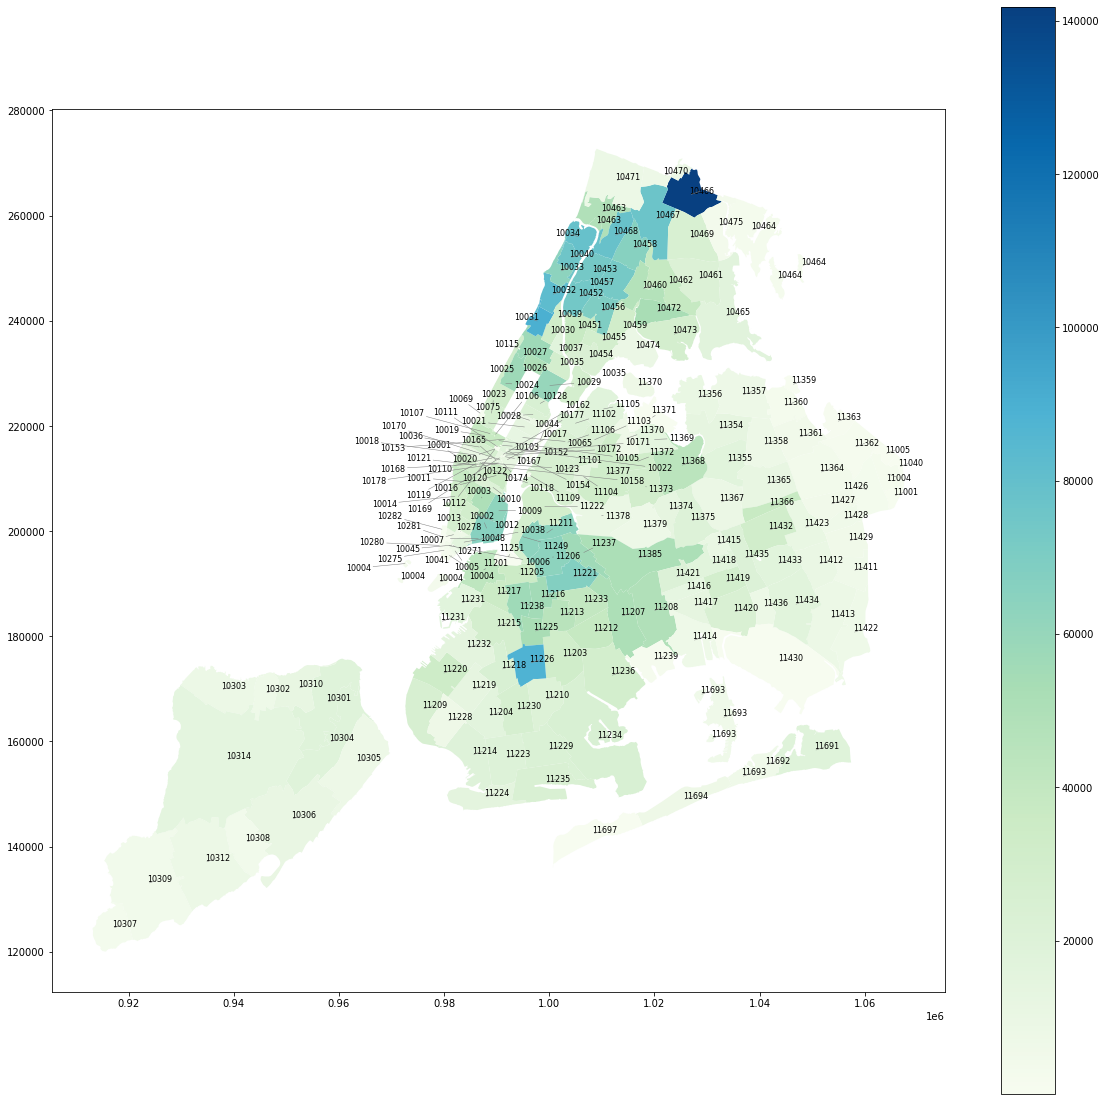

In [29]:
ax = gdf.plot("All", legend=True, figsize =  (20, 20),cmap='GnBu')
ax.set_facecolor('white')
texts = []

for x, y, label in zip(gdf_points.geometry.x, gdf_points.geometry.y, gdf_points["ZIPCODE"]):
    texts.append(plt.text(x, y, label, fontsize = 8, color='black'))

aT.adjust_text(texts, force_points=0.3, force_text=0.8, expand_points=(1,1), expand_text=(1,1), 
               arrowprops=dict(arrowstyle="-", color='gray', lw=0.5))

41

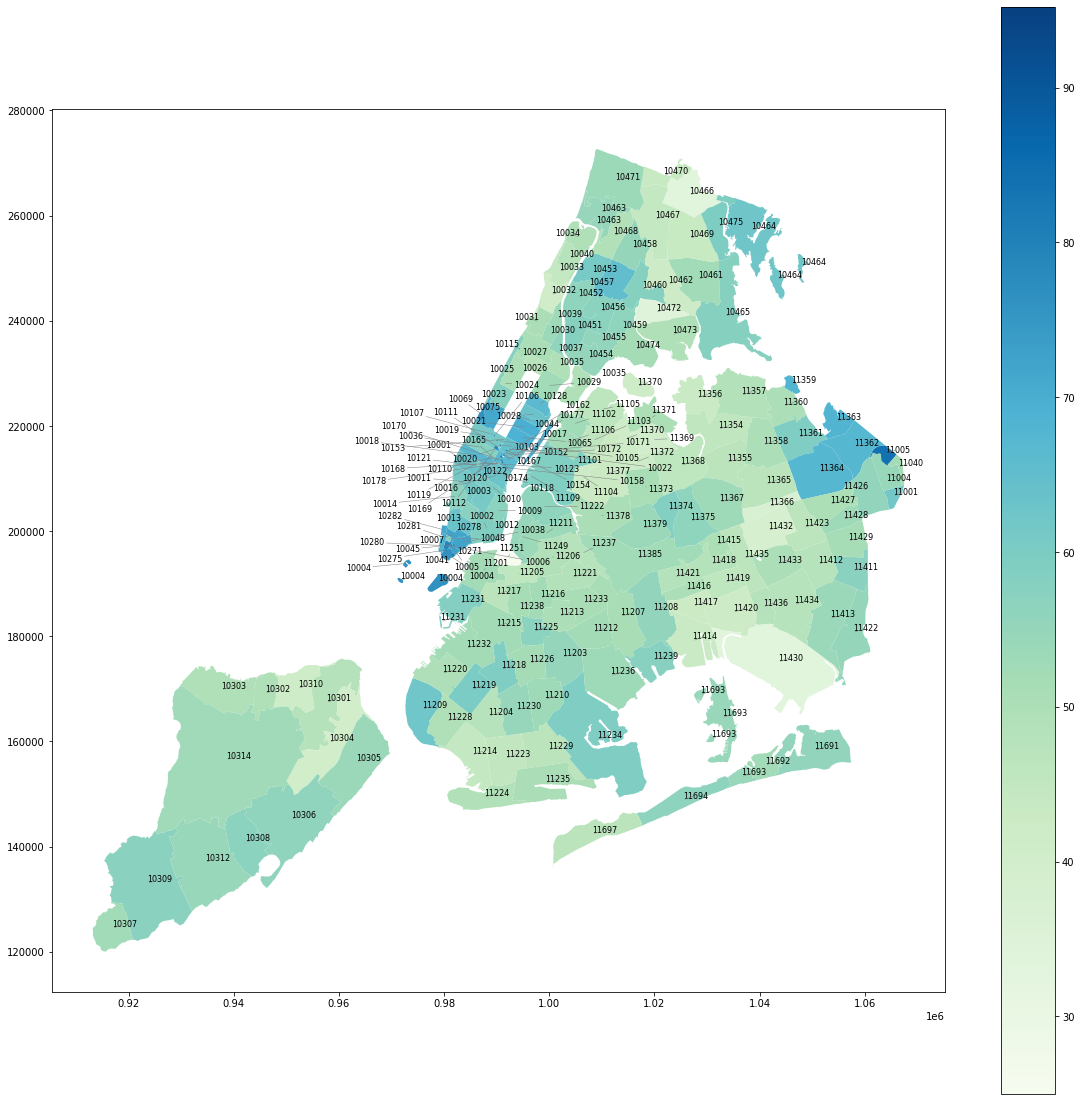

In [30]:
ax = gdf.plot("True Percent", legend=True, figsize =  (20, 20),cmap='GnBu')
ax.set_facecolor('white')
texts = []

for x, y, label in zip(gdf_points.geometry.x, gdf_points.geometry.y, gdf_points["ZIPCODE"]):
    texts.append(plt.text(x, y, label, fontsize = 8, color='black'))

aT.adjust_text(texts, force_points=0.3, force_text=0.8, expand_points=(1,1), expand_text=(1,1), 
               arrowprops=dict(arrowstyle="-", color='gray', lw=0.5))

41

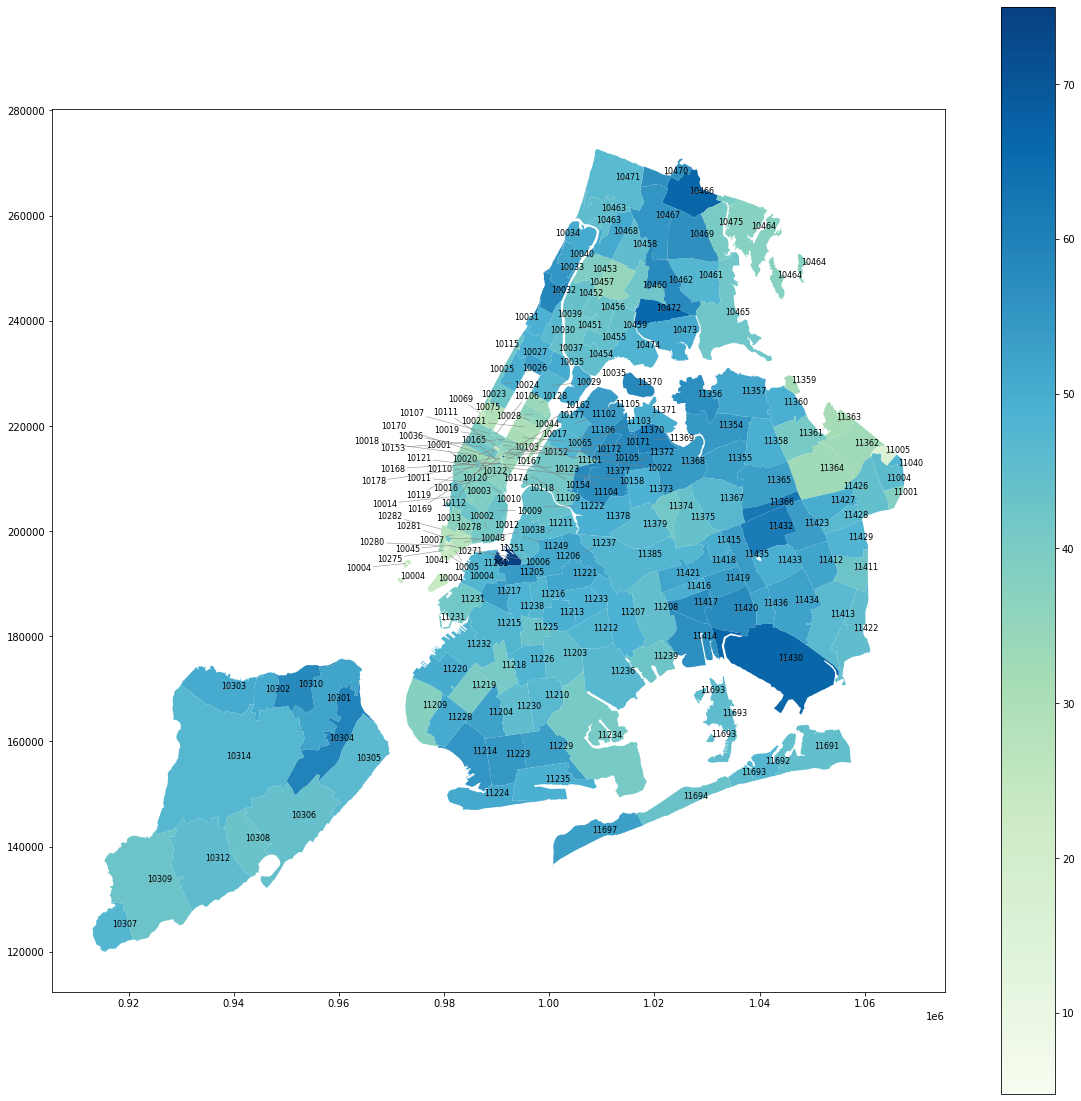

In [31]:
ax = gdf.plot("False Percent", legend=True, figsize =  (20, 20),cmap='GnBu')
ax.set_facecolor('white')
texts = []

for x, y, label in zip(gdf_points.geometry.x, gdf_points.geometry.y, gdf_points["ZIPCODE"]):
    texts.append(plt.text(x, y, label, fontsize = 8, color='black'))

aT.adjust_text(texts, force_points=0.3, force_text=0.8, expand_points=(1,1), expand_text=(1,1), 
               arrowprops=dict(arrowstyle="-", color='gray', lw=0.5))

41

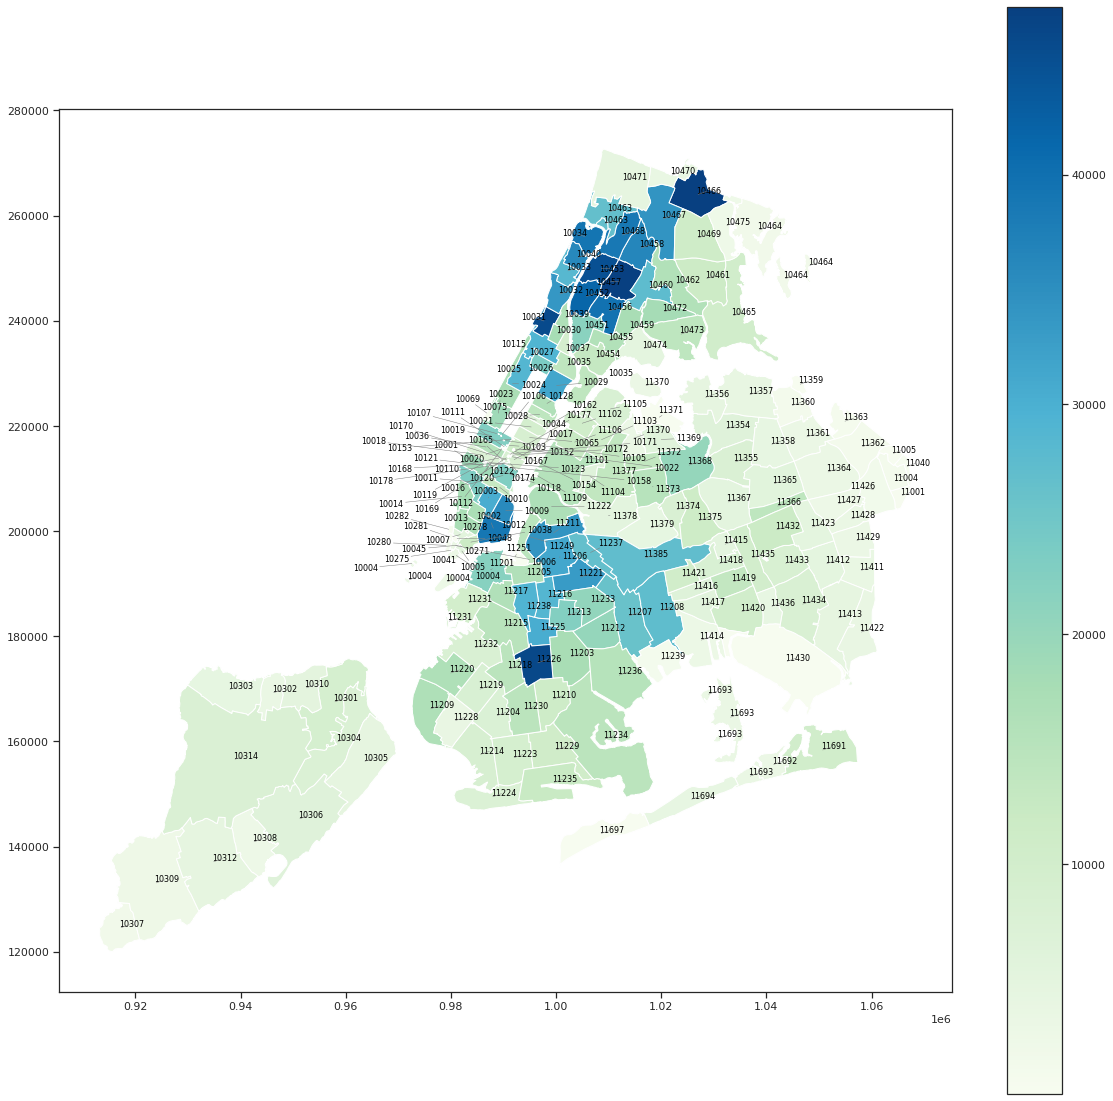

In [210]:
ax = gdf.plot("True", legend=True, figsize =  (20, 20),cmap='GnBu')
ax.set_facecolor('white')
texts = []

for x, y, label in zip(gdf_points.geometry.x, gdf_points.geometry.y, gdf_points["ZIPCODE"]):
    texts.append(plt.text(x, y, label, fontsize = 8, color='black'))

aT.adjust_text(texts, force_points=0.3, force_text=0.8, expand_points=(1,1), expand_text=(1,1), 
               arrowprops=dict(arrowstyle="-", color='gray', lw=0.5))

In [100]:
complaints_by_date = pd.to_datetime(df['Date']).dt.date.value_counts()
complaints_by_date = pd.DataFrame(complaints_by_date).reset_index()
complaints_by_date.columns = ['DATE', 'Complaints']
complaints_by_date['DATE'] =  pd.to_datetime(complaints_by_date['DATE'], format='%Y-%m-%d')
complaints_by_date.head()

,DATE,Complaints
0,2020-06-20,9114
1,2020-06-21,8654
2,2020-07-05,8448
3,2020-08-01,7209
4,2020-08-09,6867


In [143]:
df_true = df.loc[(df["Resolution"] !=  'The Police Department responded to the complaint and with the information available observed no evidence of the violation at that time.') | (df["Resolution"] ==  'The Police Department responded to the complaint and determined that police action was not necessary.')]

In [146]:
t_complaints_by_date = pd.to_datetime(df_true['Date']).dt.date.value_counts()
t_complaints_by_date = pd.DataFrame(t_complaints_by_date).reset_index()
t_complaints_by_date.columns = ['DATE', 'Complaints']
t_complaints_by_date['DATE'] =  pd.to_datetime(t_complaints_by_date['DATE'], format='%Y-%m-%d')
t_complaints_by_date.head()

,DATE,Complaints
0,2020-06-20,6148
1,2020-07-05,6093
2,2020-08-01,5450
3,2020-08-09,5184
4,2020-06-21,5013


In [111]:
import calendar
complaints_by_date["Day"] = complaints_by_date['DATE'].map(lambda x: x.day)
complaints_by_date["Month"] = complaints_by_date['DATE'].map(lambda x: x.month)
complaints_by_date["Year"] = complaints_by_date['DATE'].map(lambda x: x.year)
complaints_by_date.head()

,DATE,Complaints,Day,Month,Year
0,2020-06-20,9114,20,6,2020
1,2020-06-21,8654,21,6,2020
2,2020-07-05,8448,5,7,2020
3,2020-08-01,7209,1,8,2020
4,2020-08-09,6867,9,8,2020


In [147]:
t_complaints_by_date["Day"] = t_complaints_by_date['DATE'].map(lambda x: x.day)
t_complaints_by_date["Month"] = t_complaints_by_date['DATE'].map(lambda x: x.month)
t_complaints_by_date["Year"] = t_complaints_by_date['DATE'].map(lambda x: x.year)
t_complaints_by_date.head()

,DATE,Complaints,Day,Month,Year
0,2020-06-20,6148,20,6,2020
1,2020-07-05,6093,5,7,2020
2,2020-08-01,5450,1,8,2020
3,2020-08-09,5184,9,8,2020
4,2020-06-21,5013,21,6,2020


In [110]:
complaints_by_my = complaints_by_date.copy()
complaints_by_my = complaints_by_my.groupby(["Year","Month"]).Complaints.sum().reset_index()
complaints_by_my['Month'] = complaints_by_my['Month'].apply(lambda x: calendar.month_abbr[x])
complaints_by_my.drop(complaints_by_my.tail(1).index,inplace=True)
complaints_by_my.head()

,Year,Month,Complaints
0,2010,Jan,14202
1,2010,Feb,13278
2,2010,Mar,14903
3,2010,Apr,18382
4,2010,May,21807


In [148]:
t_complaints_by_my = t_complaints_by_date.copy()
t_complaints_by_my = t_complaints_by_my.groupby(["Year","Month"]).Complaints.sum().reset_index()
t_complaints_by_my['Month'] = t_complaints_by_my['Month'].apply(lambda x: calendar.month_abbr[x])
t_complaints_by_my.drop(t_complaints_by_my.tail(1).index,inplace=True)
t_complaints_by_my.head()

,Year,Month,Complaints
0,2010,Jan,9494
1,2010,Feb,8963
2,2010,Mar,10260
3,2010,Apr,12507
4,2010,May,15222


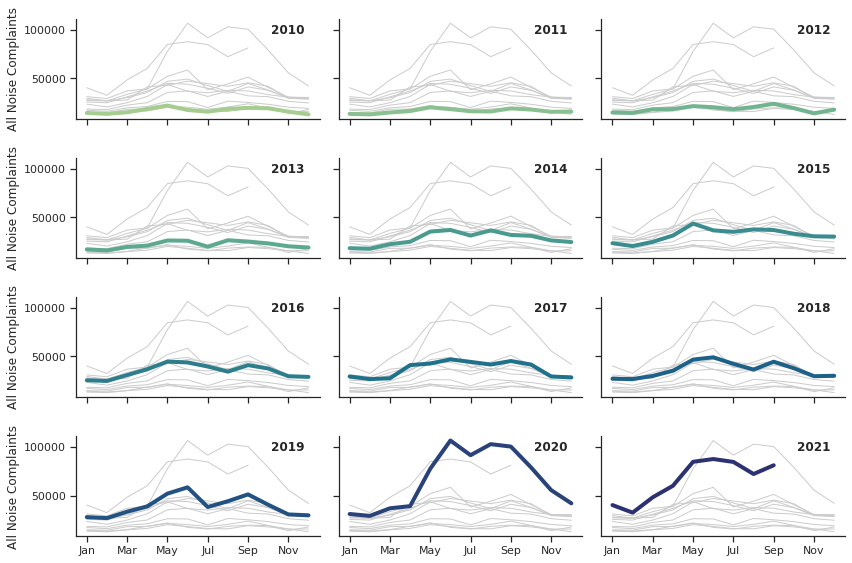

In [156]:
g = sns.relplot(
    data=complaints_by_my,
    x="Month", y="Complaints", col="Year", hue="Year",
    kind="line", palette="crest", linewidth=4, zorder=5,
    col_wrap=3, height=2, aspect=2, legend=False )

# Iterate over each subplot to customize further
for year, ax in g.axes_dict.items():

    # Add the title as an annotation within the plot
    ax.text(.8, .85, year, transform=ax.transAxes, fontweight="bold")

    # Plot every year's time series in the background
    sns.lineplot(
        data=complaints_by_my, x="Month", y="Complaints", units="Year",
        estimator=None, color=".8", linewidth=1, ax=ax,
        )

# Reduce the frequency of the x axis ticks
ax.set_xticks(ax.get_xticks()[::2])

# Tweak the supporting aspects of the plot
g.set_titles("")
g.set_axis_labels("", "All Noise Complaints")
sns.set_style("ticks")
g.tight_layout()

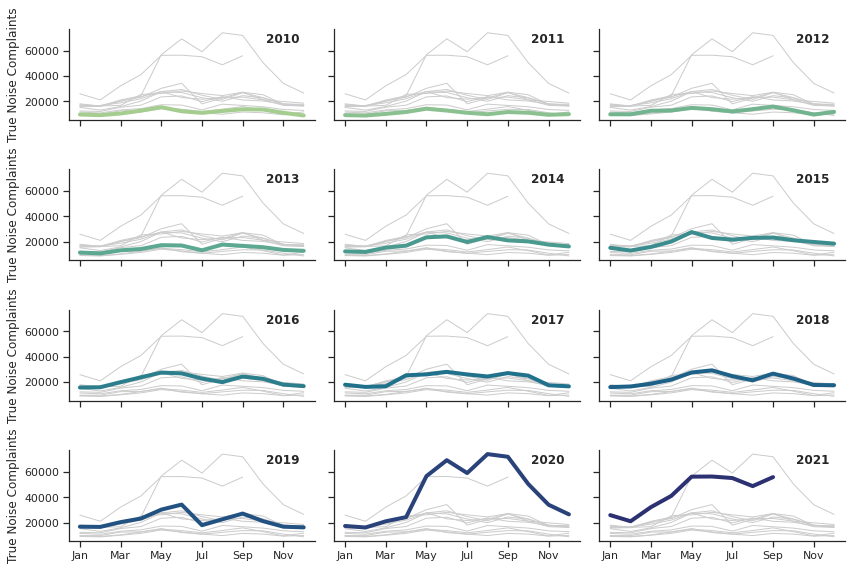

In [155]:
g = sns.relplot(
    data=t_complaints_by_my,
    x="Month", y="Complaints", col="Year", hue="Year",
    kind="line", palette="crest", linewidth=4, zorder=5,
    col_wrap=3, height=2, aspect=2, legend=False )

# Iterate over each subplot to customize further
for year, ax in g.axes_dict.items():

    # Add the title as an annotation within the plot
    ax.text(.8, .85, year, transform=ax.transAxes, fontweight="bold")

    # Plot every year's time series in the background
    sns.lineplot(
        data=t_complaints_by_my, x="Month", y="Complaints", units="Year",
        estimator=None, color=".8", linewidth=1, ax=ax,
        )

# Reduce the frequency of the x axis ticks
ax.set_xticks(ax.get_xticks()[::2])

# Tweak the supporting aspects of the plot
g.set_titles("")
g.set_axis_labels("", "True Noise Complaints")
sns.set_style("ticks")
g.tight_layout()

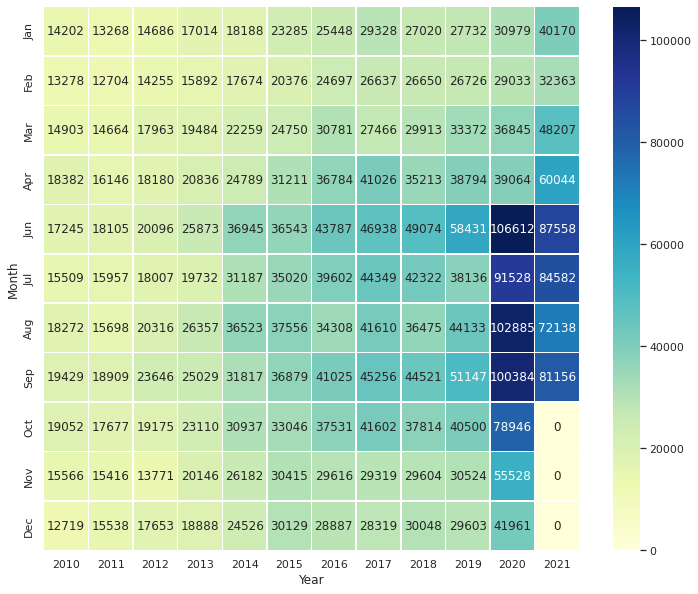

In [246]:
sns.set_theme()
complaints_by_my_piv = complaints_by_my.pivot("Month","Year", "Complaints")
complaints_by_my_piv = complaints_by_my_piv.fillna(0).astype(np.int64)
complaints_by_my_piv = complaints_by_my_piv.reindex(["Jan","Feb","Mar","Apr","Jun","Jul","Aug","Sep","Oct","Nov","Dec"])
complaints_by_my_piv
# Draw a heatmap with the numeric values in each cell
f, ax = plt.subplots(figsize=(12,10))
sns.heatmap(complaints_by_my_piv, annot=True, fmt="d", linewidths=.5, ax=ax, cmap = "YlGnBu")

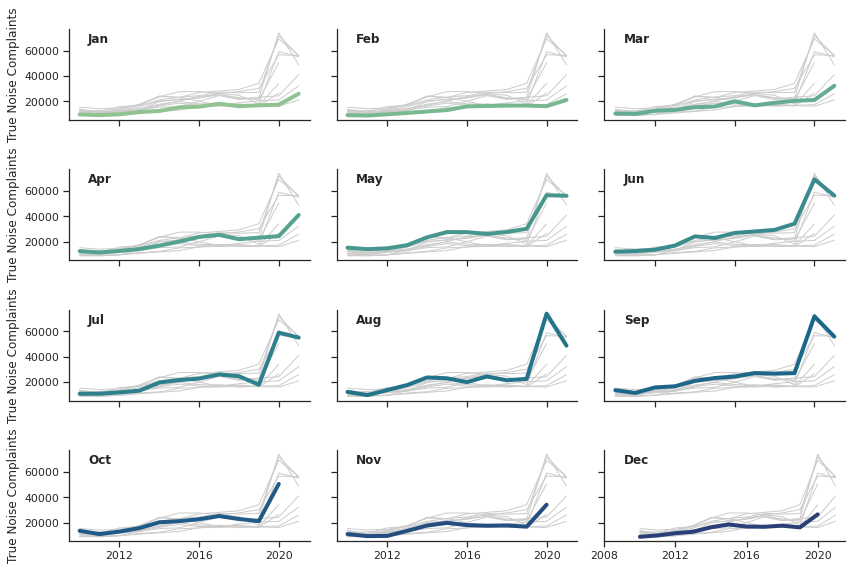

In [154]:
g = sns.relplot(
    data=t_complaints_by_my,
    x="Year", y="Complaints", col="Month", hue="Month",
    kind="line", palette="crest", linewidth=4, zorder=5,
    col_wrap=3, height=2, aspect=2, legend=False )

# Iterate over each subplot to customize further
for year, ax in g.axes_dict.items():

    # Add the title as an annotation within the plot
    ax.text(.08, .85, year, transform=ax.transAxes, fontweight="bold")

    # Plot every year's time series in the background
    sns.lineplot(
        data=t_complaints_by_my, x="Year", y="Complaints", units="Month",
        estimator=None, color=".8", linewidth=1, ax=ax,
        )

# Reduce the frequency of the x axis ticks
ax.set_xticks(ax.get_xticks()[::2])

# Tweak the supporting aspects of the plot
g.set_titles("")
g.set_axis_labels("", "True Noise Complaints")
sns.set_style("ticks")
g.tight_layout()

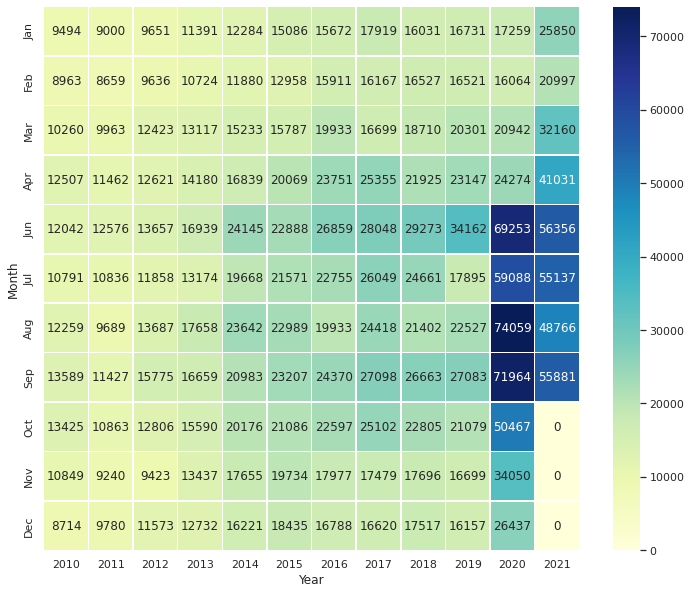

In [247]:
sns.set_theme()
complaints_by_my_piv = t_complaints_by_my.pivot("Month","Year", "Complaints")
complaints_by_my_piv = complaints_by_my_piv.fillna(0).astype(np.int64)
complaints_by_my_piv = complaints_by_my_piv.reindex(["Jan","Feb","Mar","Apr","Jun","Jul","Aug","Sep","Oct","Nov","Dec"])
complaints_by_my_piv
# Draw a heatmap with the numeric values in each cell
f, ax = plt.subplots(figsize=(12,10))
sns.heatmap(complaints_by_my_piv, annot=True, fmt="d", linewidths=.5, ax=ax, cmap = "YlGnBu")

In [202]:
aug_complaints = t_complaints_by_date.loc[t_complaints_by_date['Month'] == 8] 
aug_complaints = aug_complaints.sort_values(["Year", "Day"])
aug_complaints['Day Name'] = aug_complaints['DATE'].dt.dayofweek
aug_complaints

,DATE,Complaints,Day,Month,Year,Day Name
2797,2010-08-01,450,1,8,2010,6
3252,2010-08-02,392,2,8,2010,0
3334,2010-08-03,378,3,8,2010,1
3815,2010-08-04,306,4,8,2010,2
4135,2010-08-05,258,5,8,2010,3
...,...,...,...,...,...,...
662,2021-08-27,1040,27,8,2021,4
86,2021-08-28,2555,28,8,2021,5
76,2021-08-29,2815,29,8,2021,6
603,2021-08-30,1087,30,8,2021,0


In [196]:
aug_complaints_d = aug_complaints.copy()
aug_complaints_d = aug_complaints_d.groupby(["Year","Day Name"]).Complaints.sum().reset_index()
dayOfWeek={0:'Mon', 1:'Tue', 2:'Wed', 3:'Thu', 4:'Fri', 5:'Sat', 6:'Sun'}
aug_complaints_d['Day Name'].replace([0,1,2,3,4,5,6],['Mon','Tue','Wed','Thu','Fri','Sat','Sun'],inplace=True)
aug_complaints_d.head()

,Year,Day Name,Complaints
0,2010,Mon,1595
1,2010,Tue,1513
2,2010,Wed,1156
3,2010,Thu,1240
4,2010,Fri,1586


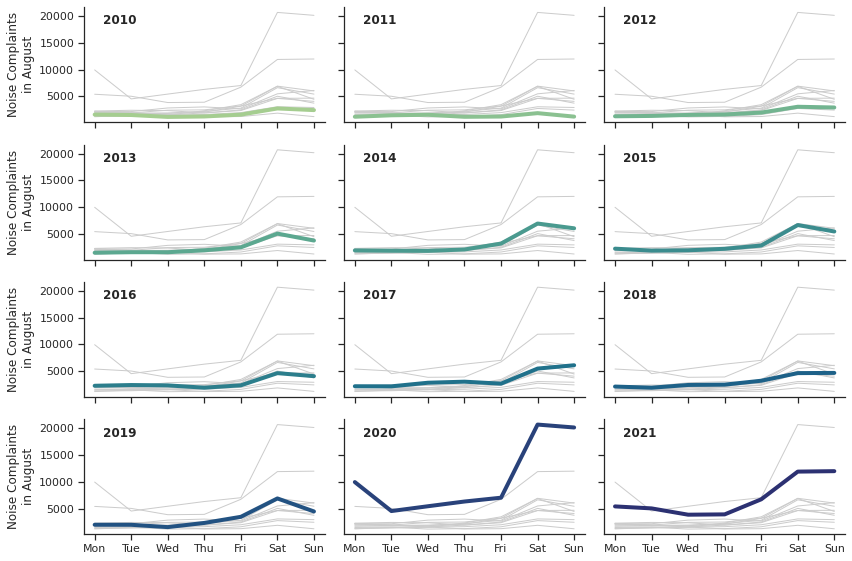

In [199]:
g = sns.relplot(
    data=aug_complaints_d,
    x="Day Name", y="Complaints", col="Year", hue="Year",
    kind="line", palette="crest", linewidth=4, zorder=5,
    col_wrap=3, height=2, aspect=2, legend=False )

# Iterate over each subplot to customize further
for year, ax in g.axes_dict.items():

    # Add the title as an annotation within the plot
    ax.text(.08, .85, year, transform=ax.transAxes, fontweight="bold")

    # Plot every year's time series in the background
    sns.lineplot(
        data=aug_complaints_d, x="Day Name", y="Complaints", units="Year",
        estimator=None, color=".8", linewidth=1, ax=ax,
        )
# Tweak the supporting aspects of the plot
g.set_titles("")
g.set_axis_labels("", "Noise Complaints\nin August")
sns.set_style("ticks")
g.tight_layout()